<a href="https://colab.research.google.com/github/yangkeyin/NN-Complex-Singularity/blob/main/%E5%AE%9E%E9%AA%8C%E8%AE%B0%E5%BD%95_20260127_%E7%9B%AE%E6%A0%87%E4%BC%AF%E6%81%A9%E6%96%AF%E5%9D%A6%E6%A4%AD%E5%9C%86%E5%8C%BA%E5%9F%9F%E5%AE%BD%E5%BA%A6%E8%B6%8A%E7%AA%84%EF%BC%8C%E6%8B%9F%E5%90%88%E6%95%88%E6%9E%9C%E4%BC%9A%E4%B8%8D%E4%BC%9A%E8%B6%8A%E5%B7%AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
使用已有文件夹: /content/drive/MyDrive/NN-Complex-Singularity
开始执行 Beta 实验序列: [0.5, 0.2, 0.1, 0.05]
------------------------------------------------------------

>>> 处理 Beta = 0.5 (目标奇点 ±0.5i)
   Epoch 0, Loss: 1.46e-01
   Epoch 2000, Loss: 1.06e-05
   Epoch 4000, Loss: 1.16e-06
   Epoch 6000, Loss: 3.04e-07
   Epoch 8000, Loss: 1.07e-07
   已保存结果图: /content/drive/MyDrive/NN-Complex-Singularity/analysis_beta_0.5.svg

>>> 处理 Beta = 0.2 (目标奇点 ±0.2i)
   Epoch 0, Loss: 2.45e-01
   Epoch 2000, Loss: 2.19e-04
   Epoch 4000, Loss: 6.10e-06
   Epoch 6000, Loss: 9.31e-07
   Epoch 8000, Loss: 5.34e-08
   已保存结果图: /content/drive/MyDrive/NN-Complex-Singularity/analysis_beta_0.2.svg

>>> 处理 Beta = 0.1 (目标奇点 ±0.1i)
   Epoch 0, Loss: 1.32e-01
   Epoch 2000, Loss: 2.12e-03
   Epoch 4000, Loss: 4.24e-05
   Epoch 6000, Loss: 2.23e-06
   Epoch 8000, Loss: 9.01e-07
   已保存结果图: /content/drive/MyDrive/NN-Complex-Singularity/analysis_beta_0.1.svg

>>> 处理 Beta = 0.05 (目标奇点 ±0.05i)
   Epoch 0, 

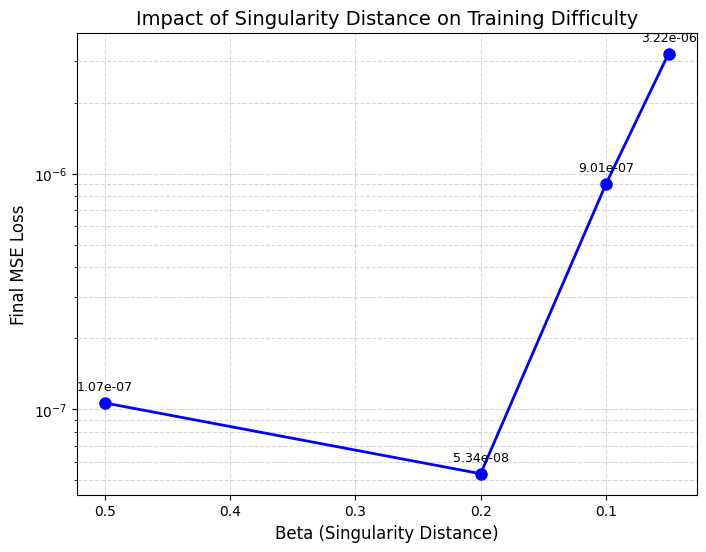

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from sklearn.linear_model import LinearRegression
import os
from google.colab import drive

# ==========================================
# 0. 环境设置与路径管理
# ==========================================
save_dir = "/content/drive/MyDrive/NN-Complex-Singularity"
drive.mount('/content/drive')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建文件夹: {save_dir}")
else:
    print(f"使用已有文件夹: {save_dir}")

# ==========================================
# 1. 基础类与辅助函数定义 (保持原始逻辑)
# ==========================================

# 动态目标函数生成器
def get_runge_function(beta):
    # 广义 Runge 函数: 1 / (1 + (x/beta)^2)
    # 奇点位于 +/- beta * i
    return lambda x: 1 / (1 + (x/beta)**2)

class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128):
        super(SimpleMLP, self).__init__()
        # 严格遵循你提供的 3 层 Linear 结构
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

def get_chebyshev_coeffs(f_vals):
    N = len(f_vals)
    coeffs = dct(f_vals, type=1) / (N - 1)
    coeffs[0] /= 2
    coeffs[-1] /= 2
    return np.abs(coeffs)

def calculate_envelope_slope(coeffs, n_bins=20, threshold=1e-12, start_k=0):
    degrees = np.arange(len(coeffs))
    k_mask = (degrees >= start_k)
    t_mask = (coeffs > threshold)
    valid_mask = k_mask & t_mask

    if np.sum(valid_mask) < 2:
        return 0.0, 0.0

    valid_coeffs = np.log(coeffs[valid_mask])
    valid_degrees = degrees[valid_mask]
    bins = np.linspace(valid_degrees.min(), valid_degrees.max(), n_bins + 1)
    which_bin = np.digitize(valid_degrees, bins)

    peak_x = []
    peak_y = []

    for i in range(1, n_bins + 1):
        mask = (which_bin == i)
        if np.any(mask):
            existing_peaks = valid_coeffs[mask]
            peak_idx = np.argmax(existing_peaks)
            peak_x.append(valid_degrees[mask][peak_idx])
            peak_y.append(existing_peaks[peak_idx])

    peak_x = np.array(peak_x).reshape(-1, 1)
    peak_y = np.array(peak_y)

    if len(peak_x) > 1:
        reg = LinearRegression()
        reg.fit(peak_x, peak_y)
        envelope_slope = -reg.coef_[0]
        intercept = reg.intercept_
    else:
        envelope_slope, intercept = 0.0, 0.0

    return envelope_slope, intercept

def get_ellipse_pts(rho, n_pts=200):
    theta = np.linspace(0, 2*np.pi, n_pts)
    z = 0.5 * (rho * np.exp(1j * theta) + (1/rho) * np.exp(-1j * theta))
    b = 0.5 * (rho - 1/rho)
    return z.real, z.imag, b

def complex_inference(model, complex_grid):
    device = next(model.parameters()).device
    z = torch.tensor(complex_grid, dtype=torch.complex64).to(device)
    layers = list(model.net.children())
    curr = z.unsqueeze(-1)
    for layer in layers:
        if isinstance(layer, nn.Linear):
            W, b = layer.weight.to(torch.complex64), layer.bias.to(torch.complex64)
            curr = torch.matmul(curr, W.t()) + b
        elif isinstance(layer, nn.Tanh):
            curr = torch.tanh(curr)
    return torch.abs(curr).squeeze().detach().cpu().numpy()

# ==========================================
# 2. 实验主循环
# ==========================================

betas = [0.5, 0.2, 0.1, 0.05]
final_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 准备复平面网格 (固定范围以便对比)
res = 400
x_val, y_val = 1.5, 0.8
X, Y = np.meshgrid(np.linspace(-x_val, x_val, res), np.linspace(-y_val, y_val, res))
complex_grid = X + 1j * Y

print(f"开始执行 Beta 实验序列: {betas}")
print("-" * 60)

for beta in betas:
    print(f"\n>>> 处理 Beta = {beta} (目标奇点 ±{beta}i)")

    # 2.1 准备当前 Beta 的数据
    current_runge = get_runge_function(beta)
    x_train = torch.cos(torch.pi * torch.linspace(0, 1, 2000)).view(-1, 1).to(device)
    y_train = current_runge(x_train) # 目标值动态变化

    # 2.2 初始化模型 (每个 Beta 重新训练)
    model = SimpleMLP(hidden_size=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # 严格遵循你的 lr=0.0001
    criterion = nn.MSELoss()

    # 2.3 训练循环
    losses = []
    for epoch in range(8001): # 跑满 8000
        optimizer.zero_grad()
        loss = criterion(model(x_train), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 2000 == 0:
            print(f"   Epoch {epoch}, Loss: {loss.item():.2e}")

    final_losses.append(losses[-1])

    # 2.4 频谱分析
    N_sample = 100
    x_cheb = np.cos(np.pi * np.arange(N_sample) / (N_sample - 1))
    y_target_np = current_runge(x_cheb)
    with torch.no_grad():
        y_model_np = model(torch.tensor(x_cheb).float().view(-1, 1).to(device)).cpu().numpy().flatten()

    coeffs_target = get_chebyshev_coeffs(y_target_np)
    coeffs_model = get_chebyshev_coeffs(y_model_np)

    # 注意：Beta 变大时收敛极快，start_k=40 可能没有数据，这里稍微调小一点 start_k
    # 但为了遵循你的指令，我尽量保持，如果报错则自动回退
    try:
        slope_t, intercept_t = calculate_envelope_slope(coeffs_target, start_k=40)
        slope_m, intercept_m = calculate_envelope_slope(coeffs_model, start_k=40)
    except:
        slope_t, intercept_t = calculate_envelope_slope(coeffs_target, start_k=10)
        slope_m, intercept_m = calculate_envelope_slope(coeffs_model, start_k=10)

    # 2.5 复平面推断
    output_abs = complex_inference(model, complex_grid)

    # ==========================================
    # 3. 绘图与保存 (单个 Beta)
    # ==========================================
    plt.figure(figsize=(18, 5))

    # 图 1: Loss 图
    plt.subplot(1, 3, 1)
    plt.semilogy(losses, color='black', lw=1.5)
    plt.title(f"1. Training (Beta={beta})\nFinal Loss: {losses[-1]:.2e}", fontsize=12)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.grid(True, which="both", alpha=0.3)

    # 图 2: 频谱系数衰减图
    rho_target = np.exp(-slope_t)
    rho_model = np.exp(-slope_m)
    k_fit = np.arange(len(coeffs_target))
    line_target = np.exp(-slope_t * k_fit + intercept_t)
    line_model = np.exp(-slope_m * k_fit + intercept_m)

    plt.subplot(1, 3, 2)
    plt.semilogy(k_fit, line_target, 'r-', lw=2, label=f'Target Fit (ρ={rho_target:.3f})')
    plt.semilogy(k_fit, line_model, 'b-', lw=2, label=f'Model Fit (ρ={rho_model:.3f})')
    plt.semilogy(k_fit, coeffs_target, 'r.', label='Target Coeffs')
    plt.semilogy(k_fit, coeffs_model, 'b:', label='Model Coeffs')
    plt.ylim(1e-12, 1)
    plt.title(f"2. Spectral Decay (Beta={beta})", fontsize=12)
    plt.xlabel("Order (k)")
    plt.legend()
    plt.grid(True, ls=":", alpha=0.6)

    # 图 3: 奇点图
    plt.subplot(1, 3, 3)
    im = plt.imshow(np.log10(output_abs + 1e-10), extent=[-x_val, x_val, -y_val, y_val],
                    origin='lower', cmap='magma', aspect='auto', vmin=-3.5, vmax=1.5)
    plt.colorbar(im, label="log10|Output|")

    # 绘制理想椭圆 (对于当前 Beta)
    # 理论 Rho = beta + sqrt(beta^2 + 1)
    rho_ideal = beta + np.sqrt(beta**2 + 1)
    ix, iy, ib = get_ellipse_pts(rho_ideal)
    plt.plot(ix, iy, 'w--', lw=1.5, label=f'Ideal Ellipse (b={ib:.3f})')

    # 绘制拟合椭圆
    tx, ty, tb = get_ellipse_pts(rho_target)
    plt.plot(tx, ty, 'y-', lw=2, label=f'Target Fit (b={tb:.3f})')
    mx, my, mb = get_ellipse_pts(rho_model)
    plt.plot(mx, my, 'cyan', linestyle=(0, (5, 5)), lw=2, label=f'Model Fit (b={mb:.3f})')

    # 标记真实极点 (当前 Beta)
    plt.scatter([0, 0], [beta, -beta], color='lime', marker='x', s=100, label=f'True Poles (±{beta}i)', zorder=5)

    plt.title(f"3. Singularity Map (Beta={beta})", fontsize=12)
    plt.xlim(-x_val, x_val)
    plt.ylim(-y_val, y_val)
    plt.legend(fontsize='small', loc='upper right')

    plt.tight_layout()

    # 保存图片
    file_name = f"analysis_beta_{beta}.svg"
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path, format="svg", bbox_inches='tight')
    print(f"   已保存结果图: {save_path}")
    plt.close() # 关闭画布以节省内存

# ==========================================
# 4. 最终汇总绘图: Beta vs Loss
# ==========================================
plt.figure(figsize=(8, 6))
plt.plot(betas, final_losses, 'bo-', lw=2, markersize=8)
plt.xlabel("Beta (Singularity Distance)", fontsize=12)
plt.ylabel("Final MSE Loss", fontsize=12)
plt.title("Impact of Singularity Distance on Training Difficulty", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.yscale('log') # 使用对数坐标，因为 Loss 变化可能很大
plt.gca().invert_xaxis() # x轴反转，从 0.5 到 0.05 (从易到难)

# 添加数值标签
for b, l in zip(betas, final_losses):
    plt.text(b, l * 1.1, f"{l:.2e}", ha='center', va='bottom', fontsize=9)

summary_path = os.path.join(save_dir, "summary_beta_vs_loss.svg")
plt.savefig(summary_path, format="svg", bbox_inches='tight')
print(f"\n实验结束！汇总图已保存: {summary_path}")
plt.show()

Mounted at /content/drive
创建文件夹: /content/drive/MyDrive/NN-Complex-Singularity//20260127BernsteinWidthVsfit//lr1e-5_20000epochs_smallbeta
开始执行 Beta 实验序列: [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
------------------------------------------------------------

>>> 处理 Beta = 0.5 (目标奇点 ±0.5i)
   Epoch 0, Loss: 3.99e-01
   Epoch 2000, Loss: 2.23e-02
   Epoch 4000, Loss: 4.59e-03
   Epoch 6000, Loss: 2.94e-03
   Epoch 8000, Loss: 7.76e-04
   Epoch 10000, Loss: 1.84e-05
   Epoch 12000, Loss: 2.44e-06
   Epoch 14000, Loss: 4.52e-07
   Epoch 16000, Loss: 2.85e-08
   Epoch 18000, Loss: 1.07e-08
   Epoch 20000, Loss: 7.48e-09
   已保存结果图: /content/drive/MyDrive/NN-Complex-Singularity//20260127BernsteinWidthVsfit//lr1e-5_20000epochs_smallbeta/analysis_beta_0.5.png

>>> 处理 Beta = 0.2 (目标奇点 ±0.2i)
   Epoch 0, Loss: 9.94e-02
   Epoch 2000, Loss: 2.45e-02
   Epoch 4000, Loss: 2.00e-02
   Epoch 6000, Loss: 8.25e-03
   Epoch 8000, Loss: 2.45e-03
   Epoch 10000, Loss: 7.75e-04
   Epoch 12000, Loss: 1.61e-04


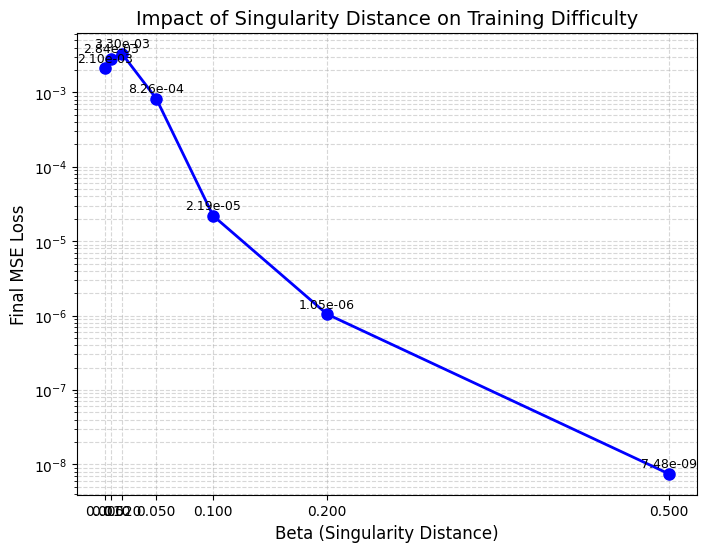

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from sklearn.linear_model import LinearRegression
import os
from google.colab import drive

# ==========================================
# 0. 环境设置与路径管理
# ==========================================
save_dir = "/content/drive/MyDrive/NN-Complex-Singularity//20260127BernsteinWidthVsfit//lr1e-5_20000epochs_smallbeta"
drive.mount('/content/drive')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建文件夹: {save_dir}")
else:
    print(f"使用已有文件夹: {save_dir}")

# ==========================================
# 1. 基础类与辅助函数定义
# ==========================================

# 动态目标函数生成器
def get_runge_function(beta):
    # 广义 Runge 函数: 1 / (1 + (x/beta)^2)
    # 奇点位于 +/- beta * i
    return lambda x: 1 / (1 + (x/beta)**2)

class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128):
        super(SimpleMLP, self).__init__()
        # 严格遵循 3 层 Linear 结构
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

def get_chebyshev_coeffs(f_vals):
    N = len(f_vals)
    coeffs = dct(f_vals, type=1) / (N - 1)
    coeffs[0] /= 2
    coeffs[-1] /= 2
    return np.abs(coeffs)

def calculate_envelope_slope(coeffs, n_bins=20, threshold=1e-12, start_k=0):
    degrees = np.arange(len(coeffs))
    k_mask = (degrees >= start_k)
    t_mask = (coeffs > threshold)
    valid_mask = k_mask & t_mask

    if np.sum(valid_mask) < 2:
        return 0.0, 0.0

    valid_coeffs = np.log(coeffs[valid_mask])
    valid_degrees = degrees[valid_mask]
    bins = np.linspace(valid_degrees.min(), valid_degrees.max(), n_bins + 1)
    which_bin = np.digitize(valid_degrees, bins)

    peak_x = []
    peak_y = []

    for i in range(1, n_bins + 1):
        mask = (which_bin == i)
        if np.any(mask):
            existing_peaks = valid_coeffs[mask]
            peak_idx = np.argmax(existing_peaks)
            peak_x.append(valid_degrees[mask][peak_idx])
            peak_y.append(existing_peaks[peak_idx])

    peak_x = np.array(peak_x).reshape(-1, 1)
    peak_y = np.array(peak_y)

    if len(peak_x) > 1:
        reg = LinearRegression()
        reg.fit(peak_x, peak_y)
        envelope_slope = -reg.coef_[0]
        intercept = reg.intercept_
    else:
        envelope_slope, intercept = 0.0, 0.0

    return envelope_slope, intercept

def get_ellipse_pts(rho, n_pts=200):
    theta = np.linspace(0, 2*np.pi, n_pts)
    z = 0.5 * (rho * np.exp(1j * theta) + (1/rho) * np.exp(-1j * theta))
    b = 0.5 * (rho - 1/rho)
    return z.real, z.imag, b

def complex_inference(model, complex_grid):
    device = next(model.parameters()).device
    z = torch.tensor(complex_grid, dtype=torch.complex64).to(device)
    layers = list(model.net.children())
    curr = z.unsqueeze(-1)
    for layer in layers:
        if isinstance(layer, nn.Linear):
            W, b = layer.weight.to(torch.complex64), layer.bias.to(torch.complex64)
            curr = torch.matmul(curr, W.t()) + b
        elif isinstance(layer, nn.Tanh):
            curr = torch.tanh(curr)
    return torch.abs(curr).squeeze().detach().cpu().numpy()

# ==========================================
# 2. 实验主循环
# ==========================================

betas = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
final_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 准备复平面网格 (固定范围以便对比)
res = 400
x_val, y_val = 1.5, 0.8
X, Y = np.meshgrid(np.linspace(-x_val, x_val, res), np.linspace(-y_val, y_val, res))
complex_grid = X + 1j * Y

print(f"开始执行 Beta 实验序列: {betas}")
print("-" * 60)

for beta in betas:
    print(f"\n>>> 处理 Beta = {beta} (目标奇点 ±{beta}i)")

    # 2.1 准备当前 Beta 的数据
    current_runge = get_runge_function(beta)
    x_train = torch.cos(torch.pi * torch.linspace(0, 1, 2000)).view(-1, 1).to(device)
    y_train = current_runge(x_train) # 目标值动态变化

    # 2.2 初始化模型 (每个 Beta 重新训练)
    model = SimpleMLP(hidden_size=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.MSELoss()

    # 2.3 训练循环
    losses = []
    for epoch in range(20001): # 跑满 8000
        optimizer.zero_grad()
        loss = criterion(model(x_train), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 2000 == 0:
            print(f"   Epoch {epoch}, Loss: {loss.item():.2e}")

    final_losses.append(losses[-1])

    # 2.4 数据准备：拟合对比与频谱分析

    # (A) 准备拟合图的数据 (Sorting for clean line plot)
    model.eval()
    with torch.no_grad():
        y_pred_train = model(x_train).cpu().numpy().flatten()
        x_train_np = x_train.cpu().numpy().flatten()
        y_train_np = y_train.cpu().numpy().flatten()

    # 对 x 进行排序以便画出连续的线
    sort_idx = np.argsort(x_train_np)
    x_sorted = x_train_np[sort_idx]
    y_true_sorted = y_train_np[sort_idx]
    y_pred_sorted = y_pred_train[sort_idx]

    # (B) 准备频谱数据
    N_sample = 100
    x_cheb = np.cos(np.pi * np.arange(N_sample) / (N_sample - 1))
    y_target_np = current_runge(x_cheb)
    with torch.no_grad():
        y_model_np = model(torch.tensor(x_cheb).float().view(-1, 1).to(device)).cpu().numpy().flatten()

    coeffs_target = get_chebyshev_coeffs(y_target_np)
    coeffs_model = get_chebyshev_coeffs(y_model_np)

    try:
        slope_t, intercept_t = calculate_envelope_slope(coeffs_target, start_k=40)
        slope_m, intercept_m = calculate_envelope_slope(coeffs_model, start_k=40)
    except:
        slope_t, intercept_t = calculate_envelope_slope(coeffs_target, start_k=10)
        slope_m, intercept_m = calculate_envelope_slope(coeffs_model, start_k=10)

    # 2.5 复平面推断
    output_abs = complex_inference(model, complex_grid)

    # ==========================================
    # 3. 绘图与保存 (单个 Beta, 4张子图)
    # ==========================================
    plt.figure(figsize=(24, 5)) # 增加宽度以容纳4张图

    # --- 图 1: Loss 图 ---
    plt.subplot(1, 4, 1)
    plt.semilogy(losses, color='black', lw=1.5)
    plt.title(f"1. Loss (Beta={beta})\nFinal: {losses[-1]:.2e}", fontsize=11)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.grid(True, which="both", alpha=0.3)

    # --- 图 2: 拟合效果图 (新增) ---
    plt.subplot(1, 4, 2)
    plt.plot(x_sorted, y_true_sorted, 'r.', markersize=1, label='True Data', alpha=0.3)
    plt.plot(x_sorted, y_pred_sorted, 'b-', lw=1, label='Model Pred', alpha=0.8)
    plt.title(f"2. Function Fitting (Beta={beta})", fontsize=11)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- 图 3: 频谱系数衰减图 ---
    rho_target = np.exp(-slope_t)
    rho_model = np.exp(-slope_m)
    k_fit = np.arange(len(coeffs_target))
    line_target = np.exp(-slope_t * k_fit + intercept_t)
    line_model = np.exp(-slope_m * k_fit + intercept_m)

    plt.subplot(1, 4, 3)
    plt.semilogy(k_fit, line_target, 'r-', lw=2, label=f'Target Fit (ρ={rho_target:.3f})')
    plt.semilogy(k_fit, line_model, 'b-', lw=2, label=f'Model Fit (ρ={rho_model:.3f})')
    plt.semilogy(k_fit, coeffs_target, 'r.', label='Target Coeffs')
    plt.semilogy(k_fit, coeffs_model, 'b:', label='Model Coeffs')
    plt.ylim(1e-12, 1)
    plt.title(f"3. Spectral Decay", fontsize=11)
    plt.xlabel("Order (k)")
    plt.legend(fontsize='small')
    plt.grid(True, ls=":", alpha=0.6)

    # --- 图 4: 奇点图 ---
    plt.subplot(1, 4, 4)
    im = plt.imshow(np.log10(output_abs + 1e-10), extent=[-x_val, x_val, -y_val, y_val],
                    origin='lower', cmap='magma', aspect='auto', vmin=-3.5, vmax=1.5)
    plt.colorbar(im, label="log10|Output|")

    # 绘制理想椭圆
    rho_ideal = beta + np.sqrt(beta**2 + 1)
    ix, iy, ib = get_ellipse_pts(rho_ideal)
    plt.plot(ix, iy, 'w--', lw=1.5, label=f'Ideal (b={ib:.3f})')

    # 绘制拟合椭圆
    tx, ty, tb = get_ellipse_pts(rho_target)
    plt.plot(tx, ty, 'y-', lw=2, label=f'Target (b={tb:.3f})')
    mx, my, mb = get_ellipse_pts(rho_model)
    plt.plot(mx, my, 'cyan', linestyle=(0, (5, 5)), lw=2, label=f'Model (b={mb:.3f})')

    # 标记真实极点
    plt.scatter([0, 0], [beta, -beta], color='lime', marker='x', s=100, label=f'Poles ±{beta}i', zorder=5)

    plt.title(f"4. Singularity Map", fontsize=11)
    plt.xlim(-x_val, x_val)
    plt.ylim(-y_val, y_val)
    plt.legend(fontsize='x-small', loc='upper right')

    plt.tight_layout()

    # 保存图片
    file_name = f"analysis_beta_{beta}.png"
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path, format="png", bbox_inches='tight')
    print(f"   已保存结果图: {save_path}")
    plt.close() # 关闭画布

# ==========================================
# 4. 最终汇总绘图: Beta vs Loss
# ==========================================
plt.figure(figsize=(8, 6))

# 1. 将 beta 和 loss 绑定并按 beta 从小到大排序
sorted_pairs = sorted(zip(betas, final_losses))
sorted_betas = [pair[0] for pair in sorted_pairs]
sorted_losses = [pair[1] for pair in sorted_pairs]

# 2. 绘图：使用排序后的数据
plt.plot(sorted_betas, sorted_losses, 'bo-', lw=2, markersize=8)
plt.xticks(sorted_betas)
plt.xlabel("Beta (Singularity Distance)", fontsize=12)
plt.ylabel("Final MSE Loss", fontsize=12)
plt.title("Impact of Singularity Distance on Training Difficulty", fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.yscale('log')

# 4. 标注数值 (使用排序后的数据)
for b, l in zip(sorted_betas, sorted_losses):
    plt.text(b, l * 1.1, f"{l:.2e}", ha='center', va='bottom', fontsize=9)

# 保存为高质量 PNG
summary_path = os.path.join(save_dir, "summary_beta_vs_loss.png")
plt.savefig(summary_path, format="png", dpi=300, bbox_inches='tight')
print(f"\n实验结束！汇总图已保存: {summary_path}")
plt.show()